In [29]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

from AE_functions import *
from eval_functions import *
from make_dataset import * 

# %matplotlib qt

import warnings
warnings.filterwarnings("ignore")


In [30]:
## Define which training model, that should be evaluated

train = '50682'

_____________________________

In [31]:
## Loading test image + outlier image

# Loading data (testset, 41 elements)
img_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/img"
heatmap_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/heatmaps"
msk_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/msk"

VerSe_test = LoadData(img_dir=img_dir_test, msk_dir = msk_dir_test, distfield_dir=heatmap_dir_test)
test_loader = DataLoader(VerSe_test, batch_size=1, shuffle=False, num_workers=0)

healthy, outlier = healthy_outlier(test_loader)

# Create datasets
dataset_healthy = generate_dataset(healthy, 120)
dataset_outlier = generate_dataset_outlier(outlier, 120, radius=30, mode="")


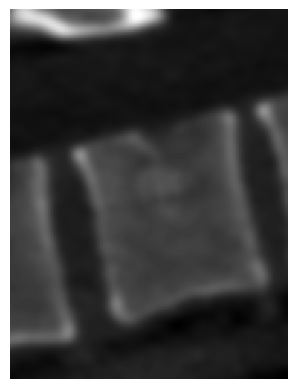

In [32]:
plt.imshow(dataset_healthy[0].squeeze(),cmap='gray')
plt.axis('off')
plt.show()

In [35]:
## Evaluating the model with new data (healthy and outliers)

# Loading the model
model_path = f'G:/Mit drev/Uni/6. semester/JK_bachelor/{train}_training/model_conv_999.pth'

model = load_model(model_path, [1, 16, 32, 64, 128])

# Testing the model with MSE
error_healthy = []
error_outlier = []

for i in range(len(dataset_healthy)):
    # test_healthy, _, _  = test_loader.dataset[i]
    test_healthy = dataset_healthy[i]
    loss = evaluate_model(model, test_healthy[0].unsqueeze(dim=0))
    error_healthy.append(loss)

    # test_outlier, _, _ = test_loader_o.dataset[i]
    test_outlier = dataset_outlier[i]
    loss = evaluate_model(model, test_outlier[0].unsqueeze(dim=0))
    error_outlier.append(loss)

-----

# MSE

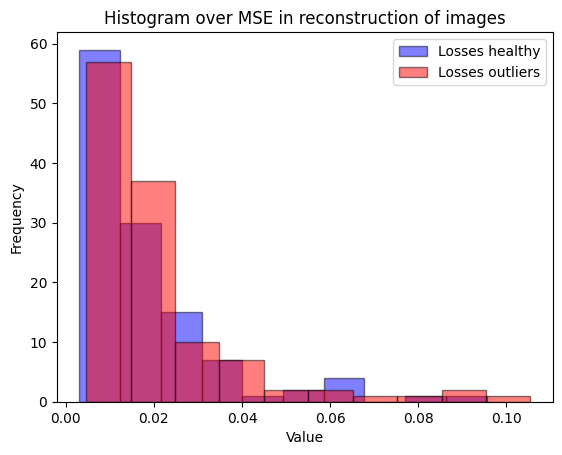

In [36]:
## Make histogram


hist_values1, hist_values2, bins1, bins2 = plot_histograms(error_healthy, error_outlier, 10)

mean_healthy = np.mean(error_healthy)
std_healthy = np.std(error_healthy)

mean_outlier = np.mean(error_outlier)
std_outlier = np.std(error_outlier)

In [37]:
print(f"Mean healthy: {mean_healthy}, std healthy: {std_healthy}")
print(f"Mean outlier: {mean_outlier}, std outlier: {std_outlier}")

Mean healthy: 0.01838989181172413, std healthy: 0.016054501021264996
Mean outlier: 0.02060083233518526, std outlier: 0.01791298642704659


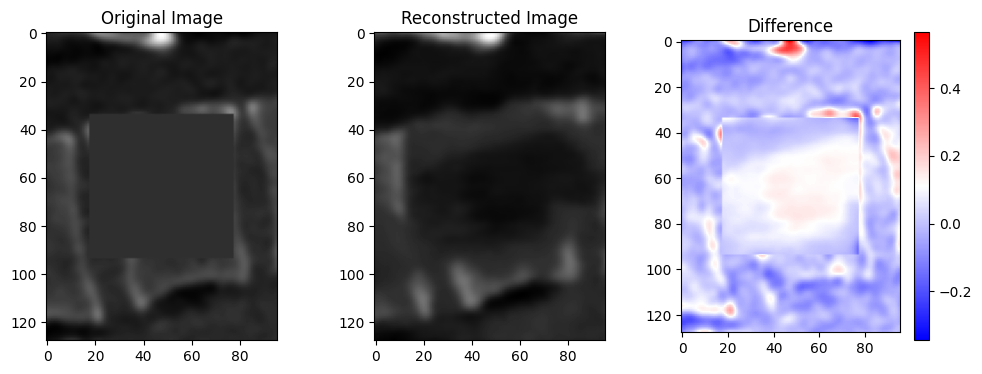

In [38]:
## Plotting the difference from outlier input to reconstructions
org_img = dataset_outlier[0].squeeze()
reconstructed_img = model(dataset_outlier[0].unsqueeze(dim=0)).squeeze().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(dataset_outlier[0].squeeze(), cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(reconstructed_img, cmap='gray')
ax[1].set_title('Reconstructed Image')

ax[2].imshow(org_img - reconstructed_img, cmap='bwr')
ax[2].set_title('Difference')
fig.colorbar(ax[2].imshow(org_img - reconstructed_img, cmap='bwr'))

plt.show()


------

# SSIM

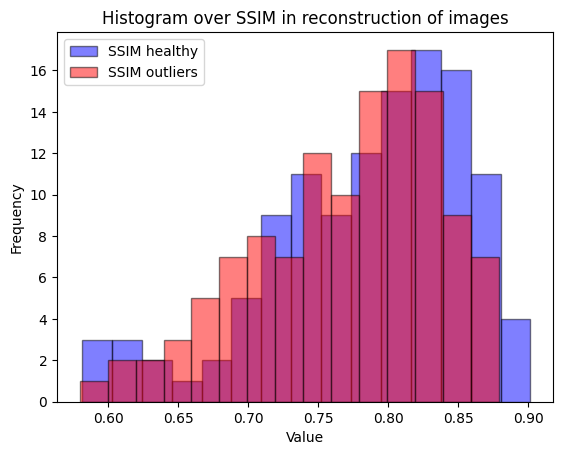

In [39]:
## Evaluating the model with new data (healthy and outliers)

# Testing the model
ssim_healthy = []
ssim_outlier = []

for i in range(len(dataset_healthy)):
    # test_healthy, _, _  = test_loader.dataset[i]
    test_healthy = dataset_healthy[i]
    loss = evaluate_model_SSIM(model, test_healthy[0].unsqueeze(dim=0))
    ssim_healthy.append(loss)

    # test_outlier, _, _ = test_loader_o.dataset[i]
    test_outlier = dataset_outlier[i]
    loss = evaluate_model_SSIM(model, test_outlier[0].unsqueeze(dim=0))
    ssim_outlier.append(loss)

hist_values1, hist_values2, bins1, bins2 = plot_histograms_SSIM(ssim_healthy, ssim_outlier, 15)

The mean structural similarity index over the image is: 0.852618031916234


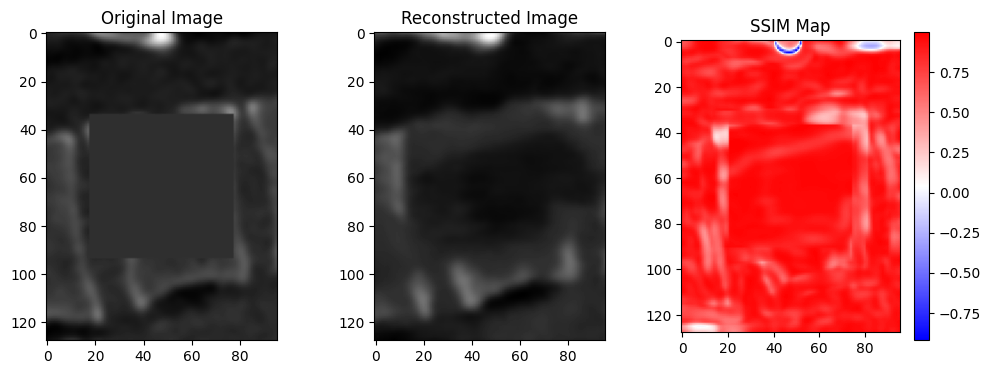

In [40]:
## Plotting the difference from outlier input to reconstructions

org_img = dataset_outlier[0].squeeze()
org_img_np = org_img.cpu().detach().numpy()

reconstructed_img = model(dataset_outlier[0].unsqueeze(dim=0)).squeeze().detach().numpy()
reconstructed_img_np = reconstructed_img.astype(np.float64)


# Compute SSIM
mssim, ssim_map  = ssim(org_img_np, reconstructed_img_np, full=True) # full=True returns the full structural similarity image
print('The mean structural similarity index over the image is:',mssim)
#plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(org_img_np, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(reconstructed_img_np, cmap='gray')
ax[1].set_title('Reconstructed Image')

ax[2].imshow(ssim_map, cmap='bwr')
ax[2].set_title('SSIM Map')
fig.colorbar(ax[2].imshow(ssim_map, cmap='bwr'))

plt.show()

-----

# Latent Space

In [41]:
# Collect latent representations for healthy and outlier data
latent_representations_healthy = collect_latent_representations(model, dataset_healthy)
latent_representations_outlier = collect_latent_representations(model, dataset_outlier)
# print(latent_representations_healthy[0].shape)


# Flatten the collected latent representations
latent_representations_healthy_flat = np.concatenate([latent.flatten().reshape(1, -1) for latent in latent_representations_healthy], axis=0)
latent_representations_outlier_flat = np.concatenate([latent.flatten().reshape(1, -1) for latent in latent_representations_outlier], axis=0)

merged = np.concatenate((latent_representations_healthy_flat, latent_representations_outlier_flat), axis=0)
target = np.zeros((merged.shape[0], 1))
target[120:] = 1

target2 = []
for i in range(merged.shape[0]):
    if i < 120:
        target2.append('Healthy')
    else:
        target2.append('Outlier')
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target2)


-----

# PCA

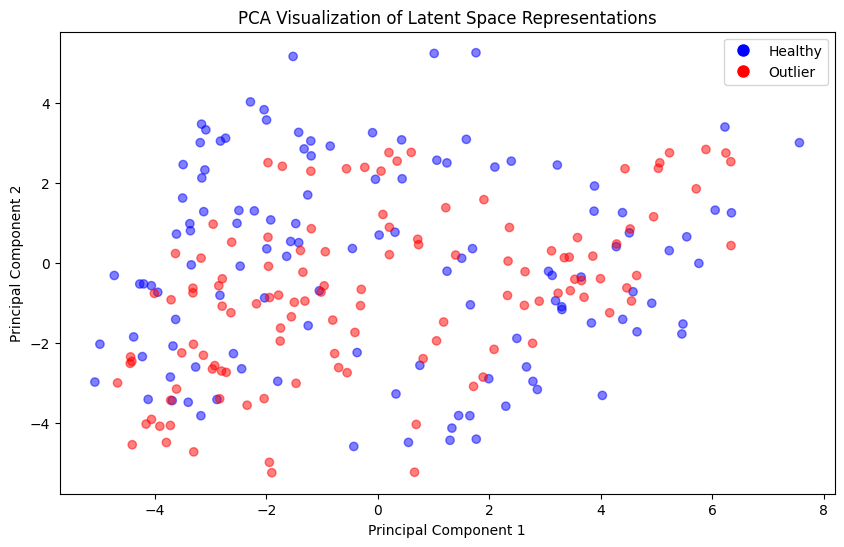

In [42]:

pca = PCA(n_components=2) 
# pca.fit(merged)
pca.fit(latent_representations_healthy_flat)

# Transform
latent_pca = pca.transform(merged)


## Plotting the PCA visualization
color_mapping = {'Healthy': 'blue', 'Outlier': 'red'}
colors = [color_mapping[label] for label in target2]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors, alpha=0.5) #, cmap='viridis')

plt.title('PCA Visualization of Latent Space Representations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Healthy', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)

plt.show()

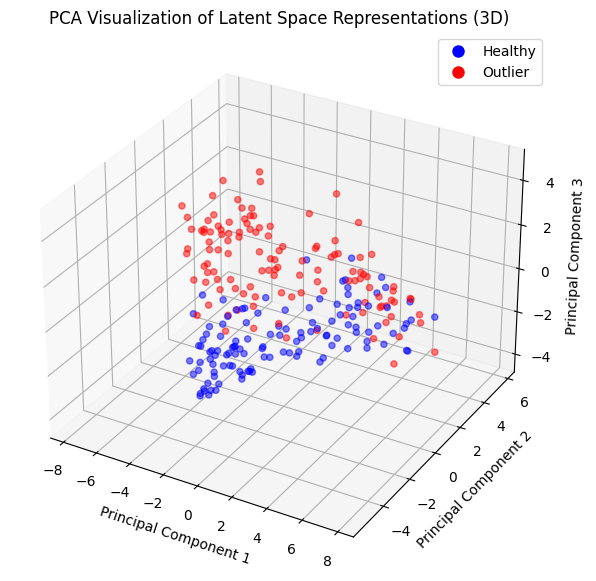

In [43]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
pca.fit(merged)
# pca.fit(latent_representations_healthy_flat)

#Transform
latent_pca = pca.transform(merged)

## Plotting the PCA visualization
color_mapping = {'Healthy': 'blue', 'Outlier': 'red'}
colors = [color_mapping[label] for label in target2]

# Plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], latent_pca[:, 2], c=colors, alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Healthy', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)

ax.set_title('PCA Visualization of Latent Space Representations (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(handles=legend_elements)
plt.show()

In [54]:
from scipy.stats import multivariate_normal

print(latent_pca.shape)
healthy_points = latent_pca[target == 0]
print(healthy_points.shape)

# Calculate the mean and covariance matrix
mean = np.mean(healthy_points, axis=0)
covariance_matrix = np.cov(healthy_points, rowvar=False)


# Define the multivariate Gaussian distribution
gaussian_distribution = multivariate_normal(mean=mean, cov=covariance_matrix)


(240, 3)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 1

----

# TSNE

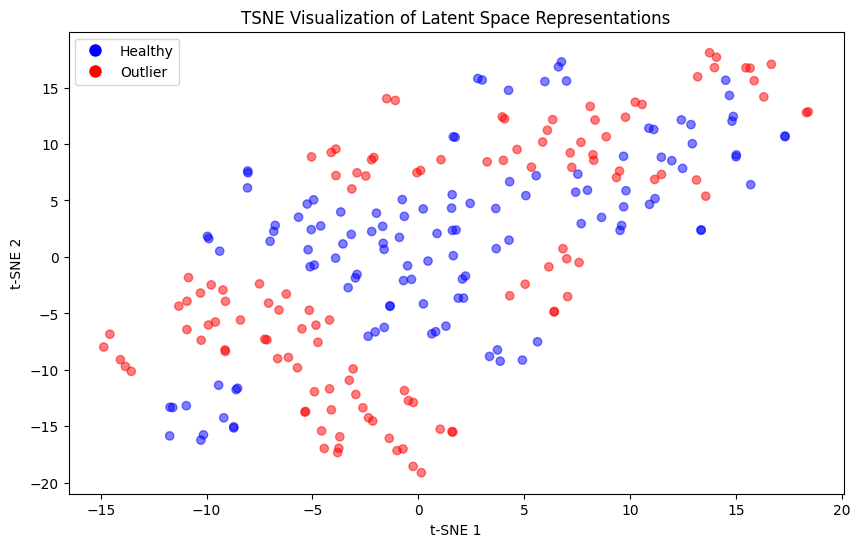

In [55]:
tsne = TSNE(n_components=2, random_state=42, perplexity=40, init='pca', learning_rate=100, n_iter=10000)

# Transform
latent_tsne = tsne.fit_transform(merged)

## Plotting the t-SNE visualization
color_mapping = {'Healthy': 'blue', 'Outlier': 'red'}
colors = [color_mapping[label] for label in target2]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=colors, alpha=0.5) #, cmap='viridis')

plt.title('TSNE Visualization of Latent Space Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Healthy', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)

plt.show()


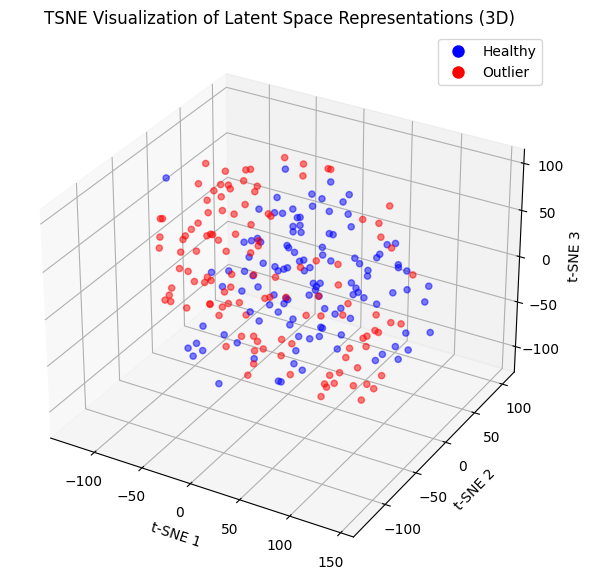

In [56]:
# Perform tsne with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30, learning_rate=100) 

# Transform
latent_tsne = tsne.fit_transform(merged)

## Plotting the t-SNE visualization
color_mapping = {'Healthy': 'blue', 'Outlier': 'red'}
colors = [color_mapping[label] for label in target2]

# Plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], latent_tsne[:, 2], c=colors, alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Healthy', markersize=10, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)

ax.set_title('TSNE Visualization of Latent Space Representations (3D)')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend(handles=legend_elements)
plt.show()